## Instruction:

Code up a momentum strategy for SPY (using the data provided) as discussed in the attached "Case Study Momentum Strategy" document.

For predictor variables, choose lagged 1W, 2W, 1M and 2M returns of S&P and 3 other Indices (Any ticker in the directory beginning with the letter "X" is an index; so XLK is the technology sector index), yielding a total of 16 variables. To calibrate the model, we used a rolling window of 100 trading days (~); re-calibration is performed once every month. The model will be used to predict the next day's return for S&P. If the next day predicted return is positive, you go long the asset, otherwise you short it.

Evaluate the following learning algorithms:

Ordinary Least Squares, Lasso, Ridge, ElasticNet and kNN, and perform the analysis as in the case study. What conclusions can you draw from your analysis?

## Answer & Analysis

### I. Section One: Data Preparation (Features Scaling)

#### Step 1: Import Necessary Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from pylab import plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error 
from math import sqrt
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn')
%matplotlib inline

<ipython-input-1-b2b2ca5eda8a>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#### Step 2: An Analysis of choosing other three Indices

In addition to the market SPY, we want to choose three other indices for our analysis. First, we just copied and pasted all of the meaning of these indices and selected based on their definition:

(1) XLB: Materials Select Sector SPDR Fund

(2) XLE: Energy Select Sector SPDR Fund

(3) XLF: Financial Select Sector SPDR Fund

(4) XLI: Industrial Select Sector SPDR Fund

(5) XLK: Technology Select Sector SPDR Fund

(6) XLP: Consumer Staples Select Sector SPDR Fund

(7) XLRE: Real Estate Select Sector SPDR Fund

(8) XLU: Utilities Select Sector SPDR Fund

(9) XLV: Health Care Select Sector SPDR Fund

(10) XLY: Consumer Discretionary Select Sector SPDR Fund

(11) SPY: SPDR S&P 500 ETF Trust

Also, based on the information for SPY, which tracks S&P 500 index. For S&P 500, the order of the 11 sectors based on size is as follows: **Information Technology**, **Health Care**, **Consumer Discretionary**, Communication Services, Financials, Industrials, Consumer Staples, Utilities, Real Estate, Materials, and Energy.

Note that I citedt this ordering from this link:

https://advisor.visualcapitalist.com/sp-500-sectors-and-industries/

According to the definitions above and the three biggest sector of S&P 500, `XLK`, `XLV`, and `XLY` are the good fit for predicting returns for SPY, which tracks S&P 500 index. The logic behind is that `XLK`, `XLV`, and `XLY`, the measurement of financial institutions, health care, and consumer discretionary, are the three most important measurement criteria for predicting market trends (i.e., three largest sectors in S&P500), compared with other also important sectors. In my opinion, it is good to keep all of the indexes. However, here we are only allowed to keep three of them. So, as a result, I chose `XLK`, `XLV`, and `XLY`.

#### Step 3: Load the Dataset

In [2]:
# Load SPY
spy_df = pd.read_csv('SPY.csv')

# Load other three indexes indicated above
xlk_df = pd.read_csv('XLK.csv')
xlv_df = pd.read_csv('XLV.csv')
xly_df = pd.read_csv('XLY.csv')

#### Step 4: Transform the Dataset to Returns (Features Scaling)

In [3]:
# Create the function price_to_return(data)
def price_to_return(data):
    data['Returns'] = data['Close'] / data['Close'].shift(1) - 1
    return data

In [4]:
spy = price_to_return(spy_df)
xlk = price_to_return(xlk_df)
xlv = price_to_return(xlv_df)
xly = price_to_return(xly_df)

In [5]:
# Drop NaN
spy.dropna(inplace = True)
xlk.dropna(inplace = True)
xlv.dropna(inplace = True)
xly.dropna(inplace = True)

#### Step 5: Obtain all Xs values and Generate our Corresponding Dataset

In [6]:
# First, I renamed the columns for "spy", "xlk", "xlv", and "xly"
spy = spy.rename(columns = {'Close': 'SPY'})
xlk = xlk.rename(columns = {'Close': 'XLK'})
xlv = xlv.rename(columns = {'Close': 'XLV'})
xly = xly.rename(columns = {'Close': 'XLY'})

In [7]:
# Second, define the function helping us obtain all the predictors' dataset
def lagged_xs(df_lst, lag_lst):
    result_lst = [0 for i in range(len(df_lst)*len(lag_lst))]
    index = 0
    for df in df_lst:
        for lag in lag_lst:
            df[df.columns[1] + '_Lag_' + str(lag)] = df['Returns'].shift(lag)
            result_lst[index] = df[[df.columns[1] + '_Lag_' + str(lag)]]
            index += 1
            
    x_dataset = pd.concat(result_lst, axis = 1)
    return x_dataset

In [8]:
x = lagged_xs([spy, xlk, xlv, xly], [5, 10, 20, 40])

In [9]:
x.dropna(inplace = True)

In [10]:
## Take a look at x
x

,SPY_Lag_5,SPY_Lag_10,SPY_Lag_20,SPY_Lag_40,XLK_Lag_5,XLK_Lag_10,XLK_Lag_20,XLK_Lag_40,XLV_Lag_5,XLV_Lag_10,XLV_Lag_20,XLV_Lag_40,XLY_Lag_5,XLY_Lag_10,XLY_Lag_20,XLY_Lag_40
41,-0.006261,0.014685,-0.006630,0.002057,0.000893,0.017944,-0.009105,0.001714,-0.011006,0.009379,-0.002731,0.001445,-0.003054,0.013587,-0.002752,0.002727
42,-0.004974,0.002487,-0.010257,-0.003770,-0.006395,0.002474,-0.009043,-0.005289,-0.004143,0.000724,-0.021032,-0.006131,-0.001436,0.005186,-0.004968,-0.005843
43,0.001296,0.013496,0.000497,0.007157,0.001197,0.018356,0.007507,0.012353,-0.001545,0.011335,-0.014211,0.011248,0.001246,0.015964,-0.003236,0.015199
44,0.015939,0.012760,-0.001135,0.006325,0.020930,0.019085,0.000877,0.008341,0.015954,0.011089,0.000341,0.009568,0.013978,0.008911,-0.011131,0.004591
45,0.011612,0.000293,-0.021770,0.004215,0.015668,-0.001486,-0.029631,0.005055,0.012657,0.007193,-0.014070,0.001422,0.008403,-0.004843,-0.009568,0.003279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.019618,0.001897,-0.006679,0.017941,-0.021217,0.013777,-0.009123,0.034390,-0.019897,0.003865,0.001452,0.012945,-0.025408,0.000774,-0.004489,0.030212
250,-0.001096,0.000227,0.016144,-0.017587,0.007911,0.001222,0.022628,-0.020006,-0.008717,0.003080,0.009705,-0.011310,0.007821,0.000387,0.022447,-0.031107
251,-0.014976,0.005035,0.003364,-0.005540,-0.019780,0.007778,0.001984,-0.016889,-0.013074,0.008554,0.010386,0.002517,-0.019799,0.010532,0.002972,-0.008800
252,-0.016278,-0.000339,0.023025,0.014818,-0.017937,0.001665,0.035029,0.011204,-0.014068,0.000979,0.024057,0.010726,-0.022432,-0.004972,0.029535,0.015024


In [11]:
# Third, I wanted to combine "x" with "y", which is "spy[["Returns"]]" in this case.
## I dropped the Nan for SPY dataset "spy"
spy.dropna(inplace = True)
## Rename the columns 'Returns' for "spy" once again to make it more convenient
spy = spy.rename(columns = {'Returns': 'SPY_Ret'})

In [12]:
## Combination: Note that I added 'Dt' in "y" also just for the convenice (it is nice to see the actual date)
data = pd.concat([spy[['Dt', 'SPY_Ret']], x], axis = 1)

## Take a look at data
data

,Dt,SPY_Ret,SPY_Lag_5,SPY_Lag_10,SPY_Lag_20,SPY_Lag_40,XLK_Lag_5,XLK_Lag_10,XLK_Lag_20,XLK_Lag_40,XLV_Lag_5,XLV_Lag_10,XLV_Lag_20,XLV_Lag_40,XLY_Lag_5,XLY_Lag_10,XLY_Lag_20,XLY_Lag_40
41,2018-02-27,-0.012487,-0.006261,0.014685,-0.006630,0.002057,0.000893,0.017944,-0.009105,0.001714,-0.011006,0.009379,-0.002731,0.001445,-0.003054,0.013587,-0.002752,0.002727
42,2018-02-28,-0.010130,-0.004974,0.002487,-0.010257,-0.003770,-0.006395,0.002474,-0.009043,-0.005289,-0.004143,0.000724,-0.021032,-0.006131,-0.001436,0.005186,-0.004968,-0.005843
43,2018-03-01,-0.014541,0.001296,0.013496,0.000497,0.007157,0.001197,0.018356,0.007507,0.012353,-0.001545,0.011335,-0.014211,0.011248,0.001246,0.015964,-0.003236,0.015199
44,2018-03-02,0.005155,0.015939,0.012760,-0.001135,0.006325,0.020930,0.019085,0.000877,0.008341,0.015954,0.011089,0.000341,0.009568,0.013978,0.008911,-0.011131,0.004591
45,2018-03-05,0.011558,0.011612,0.000293,-0.021770,0.004215,0.015668,-0.001486,-0.029631,0.005055,0.012657,0.007193,-0.014070,0.001422,0.008403,-0.004843,-0.009568,0.003279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2018-12-24,-0.026423,-0.019618,0.001897,-0.006679,0.017941,-0.021217,0.013777,-0.009123,0.034390,-0.019897,0.003865,0.001452,0.012945,-0.025408,0.000774,-0.004489,0.030212
250,2018-12-26,0.050525,-0.001096,0.000227,0.016144,-0.017587,0.007911,0.001222,0.022628,-0.020006,-0.008717,0.003080,0.009705,-0.011310,0.007821,0.000387,0.022447,-0.031107
251,2018-12-27,0.007677,-0.014976,0.005035,0.003364,-0.005540,-0.019780,0.007778,0.001984,-0.016889,-0.013074,0.008554,0.010386,0.002517,-0.019799,0.010532,0.002972,-0.008800
252,2018-12-28,-0.001290,-0.016278,-0.000339,0.023025,0.014818,-0.017937,0.001665,0.035029,0.011204,-0.014068,0.000979,0.024057,0.010726,-0.022432,-0.004972,0.029535,0.015024


In [13]:
## Obtain a summary statistics for our dataset
data.describe()

,SPY_Ret,SPY_Lag_5,SPY_Lag_10,SPY_Lag_20,SPY_Lag_40,XLK_Lag_5,XLK_Lag_10,XLK_Lag_20,XLK_Lag_40,XLV_Lag_5,XLV_Lag_10,XLV_Lag_20,XLV_Lag_40,XLY_Lag_5,XLY_Lag_10,XLY_Lag_20,XLY_Lag_40
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,-0.000444,-0.000546,0.000027,-0.000161,0.000103,-0.000496,0.000171,-0.000031,0.000444,-0.000101,0.000426,0.000176,0.000358,-0.000457,0.000131,-0.000015,0.000349
std,0.010428,0.009737,0.009509,0.010050,0.009527,0.013980,0.013752,0.014099,0.012962,0.010128,0.009947,0.010307,0.009972,0.011442,0.011087,0.011228,0.010520
min,-0.032402,-0.032402,-0.032402,-0.041822,-0.041822,-0.048460,-0.048460,-0.048460,-0.048460,-0.033674,-0.033674,-0.044309,-0.044309,-0.035997,-0.035997,-0.039877,-0.039877
25%,-0.005224,-0.005224,-0.004489,-0.005132,-0.003770,-0.007137,-0.006012,-0.006658,-0.005178,-0.005399,-0.004279,-0.004332,-0.003636,-0.005025,-0.004799,-0.004843,-0.004460
50%,0.000034,0.000034,0.000242,0.000178,0.000483,0.000573,0.001115,0.000573,0.001116,0.000801,0.000985,0.000842,0.001303,0.001051,0.001350,0.001061,0.001533
75%,0.005032,0.004929,0.005155,0.005155,0.005381,0.007462,0.007690,0.007507,0.007599,0.005525,0.005795,0.005795,0.005936,0.005866,0.006441,0.005969,0.006689
max,0.050525,0.027359,0.027359,0.027359,0.027359,0.037959,0.037959,0.037959,0.037959,0.029389,0.029389,0.029389,0.027421,0.030212,0.030212,0.030212,0.030212


At this stage, we just restructured our raw data downloaded into the dataset we can directly use for our models. Note that the overall dataset containing x and y (`spy[['Dt', 'SPY_Ret']]`) is `data`, which may be convenient for later use (but not for the next section). 

### II. Section Two: Model Recalibration Preparation (Has not Entered the Real Models Yet)

#### Step 6: Data Split: Recalibrate Once a Month

In short, I used a rolling windows of 100 trading days (train size) and the last 20 days (rows) for our test days, since we recalibrate our models monthly (which corresponds to 20 trading days). So, our parameter `window` (input) to our below function `data_split` is `120` (100 + 20). *Note that the number of recalibration group is calculated as  a the integer part of the difference between the number of avaliable data (len(data) = 213) and the window size (120) plus one (just a simple math fact)*.

Also, note that here for the convenience for the function `data_split`, I used the paramemters `x` and `spy[['Dt', 'SPY_Ret']]` (y) as input, not `data`, which combines x and y.


In [14]:
# Step 1: Define a Function Containing Each of the Recalibration Pairs, with a Rolling Window 100 days
## Note that the last 20 rows (days) in each pair are the testing days
def data_split(x, y, window):
    "Return a list containing the list of x and y pairs. So it returns a 2-D list"
    data = pd.concat([spy[['Dt', 'SPY_Ret']], x], axis = 1)
    num_group = int((len(data) - window)/20) + 1
    recab_lst = [0 for i in range(num_group)]
    index = 0
    for i in range(num_group):
        recab_x = x.iloc[index: index + window, :]
        recab_y = y.iloc[index: index + window, :]
        recab_lst[i] = [recab_x, recab_y]
        
        index += 20
        
    return recab_lst

In [15]:
## Define such 2-D list
pair_lst = data_split(x, spy[['Dt', 'SPY_Ret']], 120)

Ok, so now we have a 2D list containing all of the required recalibration pair. Note that each element of the 2D list `pair_lst` is also a list of length 2. With the first element always being the x recalibration pair, the second the y recalibration pair.

### III. Section Three: Use OLS, Lasso, Ridge, ElasticNet, and kNN Models

#### Step 7: Select the Best Models for Each of These Five Models (Based on the Criteria of Smallest SME)

Here, I applied Ols, Lasso, Ridge, ElasticNet, and kNN models  for each of these five sub-dataset, and selcetd the best one for each of these five models. The selection creteria is that I will always select the model which has the smallest mean squared error.

In [16]:
def best_model(data, trading_days, model, alpha= None, nn = None, ls = None, p = None):
    # Initialize some parameters
    mse = float('inf')
    best_model = None
    
    # Begin our model selection
    if model == "OLS":
        for pair in data:
            ols = linear_model.LinearRegression()
            ols.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            y_train = ols.predict(pair[0].iloc[trading_days:, :])
            mse_pair = mean_squared_error(pair[1].iloc[trading_days:, 1], y_train)
            
            # Determine whether "mse_pair" < "mse" or not
            if mse_pair < mse:
                mse = mse_pair
                best_model = ols
            
        return best_model
            
    elif model == "Lasso":
        for pair in data:
            lasso = linear_model.Lasso(alpha)
            lasso.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            y_train = lasso.predict(pair[0].iloc[trading_days:, :])
            mse_pair = mean_squared_error(pair[1].iloc[trading_days:, 1], y_train)
            
            # Determine whether "mse_pair" < "mse" or not
            if mse_pair < mse:
                mse = mse_pair
                best_model = lasso
            
        return best_model
        
    elif model == "Ridge":
        for pair in data:
            ridge = linear_model.Ridge(alpha)
            ridge.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            y_train = ridge.predict(pair[0].iloc[trading_days:, :])
            mse_pair = mean_squared_error(pair[1].iloc[trading_days:, 1], y_train)
            
            # Determine whether "mse_pair" < "mse" or not
            if mse_pair < mse:
                mse = mse_pair
                best_model = ridge
            
        return best_model
    
    elif model == "ElasticNet":
        for pair in data:
            elastic = linear_model.ElasticNet(alpha)
            elastic.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            y_train = elastic.predict(pair[0].iloc[trading_days:, :])
            mse_pair = mean_squared_error(pair[1].iloc[trading_days:, 1], y_train)
            
            # Determine whether "mse_pair" < "mse" or not
            if mse_pair < mse:
                mse = mse_pair
                best_model = elastic

        return best_model
        
    elif model == "kNN":
        for pair in data:
            knn = KNeighborsClassifier(n_neighbors=nn, leaf_size=ls, p=p)
            knn.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            y_train = knn.predict(pair[0].iloc[trading_days:, :])
            mse_pair = mean_squared_error(pair[1].iloc[trading_days:, 1], y_train)
            
            # Determine whether "mse_pair" < "mse" or not
            if mse_pair < mse:
                mse = mse_pair
                best_model = knn
    
        return best_model

Now, I just have created a function to help us select the best model for each of these five models. Please pay attention that most of these models need some additional (like `alpha`, `n_neighbors`, `leaf_size`, and `p`) information for use to proceed. So, we have to determine these hyperparamters in the next step.

#### Step 8: Determine the Best Parameters for Lasso, Ridge, ElasticNet, and kNN

Here I used the `GridSearchCV` for parameter selctions for all the models. Just note that for kNN model, I used `KNeighborsClassifier` as well.

In [17]:
# Step 1: define "parameter_selection" function for Lasso, Ridge, Elastic Net Models
def parameter_selection(data, trading_days, model, param_grid):
    lst = []
    if model == "Lasso":
        for pair in data:
            grid = GridSearchCV(linear_model.Lasso(), param_grid, cv=5)
            grid.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            lst.append(grid.best_params_)
            
        return lst
    
    elif model == "Ridge":
        for pair in data:
            grid = GridSearchCV(linear_model.Ridge(), param_grid, cv=5)
            grid.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            lst.append(grid.best_params_)
            
        return lst
    
    elif model == "ElasticNet":
        for pair in data:
            grid = GridSearchCV(linear_model.ElasticNet(), param_grid, cv=5)
            grid.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            lst.append(grid.best_params_)
            
        return lst
    
    elif model == "kNN":
        for pair in data:
            grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
            grid.fit(pair[0].iloc[:trading_days, :], pair[1].iloc[:trading_days, 1])
            lst.append(grid.best_params_)
            
        return lst
            
            

Now we set our default values for our alphas selection. Here for simplicity, I used `list(np.arange(0, 10.1, 0.1))` as our alphas' candidate. In real world, it is better to choose alphas ranging from 0 to 100. However, here I just picked alphas ranging from 0 to 10 to make the computer's life easy.

In [18]:
## Define our "param_grid"
param_grid = {'alpha':list(np.arange(0, 10.1, 0.1))}

# Step 2: Call our "parameter_selection" function for "Lasso" model
parameter_selection(pair_lst, 100, "Lasso",  param_grid)


/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-03, tolerance: 4.696e-07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

[{'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1}]

In [19]:
# Step 3: Call our "parameter_selection" function for "Ridge" model
parameter_selection(pair_lst, 100, "Ridge", param_grid)


[{'alpha': 10.0},
 {'alpha': 10.0},
 {'alpha': 0.1},
 {'alpha': 10.0},
 {'alpha': 0.1}]

In [20]:
# Step 4: Call our "parameter_selection" function for "ElasticNet" model
parameter_selection(pair_lst, 100, "ElasticNet", param_grid)


/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/hejifan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-03, tolerance: 4.696e-07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

[{'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1},
 {'alpha': 0.1}]

Next, let's deal explicitly with kNN models. First, we need to transform y to a series of 0 and 1 values. If the daily returns > 0, then the corresponding transformed value y is 1, otherwise is 0.  

In [21]:
## Here, I did the corresponding transformation of "spy[['SPY_Ret']]"
y = spy[['SPY_Ret']]

lst = [0 for i in range(len(y))]
for i in range(len(y)):
    if y['SPY_Ret'].iloc[i] > 0:
        lst[i] = 1
    else:
        lst[i] = 0
        
y['P&L'] = lst
y

<ipython-input-21-41545f546c14>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['P&L'] = lst


,SPY_Ret,P&L
41,-0.012487,0
42,-0.010130,0
43,-0.014541,0
44,0.005155,1
45,0.011558,1
...,...,...
249,-0.026423,0
250,0.050525,1
251,0.007677,1
252,-0.001290,0


Now I have to define a different `param_grid` than the previous one. Note that for avaliable candidates for `n_neighbors`, "An odd number is preferred to avoid any tie." (relveant quote source: https://ashokharnal.wordpress.com/tag/kneighborsclassifier-explained/#:~:text='n_neighbors'%20are%20the%20number%20of,uniform'%20and%20'distance'.).

In [22]:
## Define our "param_grid"
param_grid = {'leaf_size':[5, 10, 15, 20, 25, 30], 'n_neighbors':[3, 5, 7, 9, 11], 'p': [1, 2]}

## Define a new 2-D list
new_pair_lst = data_split(x, y, 120)


In [23]:
# Step 5: Now, employ our "parameter_selection" function for kNN model
lst = parameter_selection(new_pair_lst, 100, "kNN", param_grid)
lst

[{'leaf_size': 5, 'n_neighbors': 5, 'p': 1},
 {'leaf_size': 5, 'n_neighbors': 5, 'p': 2},
 {'leaf_size': 5, 'n_neighbors': 7, 'p': 2},
 {'leaf_size': 5, 'n_neighbors': 5, 'p': 1},
 {'leaf_size': 5, 'n_neighbors': 5, 'p': 2}]

Now, we have obtained some basic information on our parameters. For Lasso model, alphas of 0.1 is the best fit. For Ridge model, we have 10, and 0.1. For ElasticNet model, we have 0.1 also. For kNN model. Things get a little bit of tricker: we have several avaliable combinations.

Here, I decide to use `alpha = 0.1` for Lasso model, `alpha = 10` (adding more penalization) for Ridge model, `alpha = 0.1` for ElasticNet model, and `leaf_size = 5`, `n_neighbors = 5`, and `p = 1` (for simplicity, just pick the first element of `lst`).


#### Step 9: Call our Best Model for Each of These Five Model Candidates

Here I basically called the `best_model` function defined in step 7 for each of the models I used.

In [24]:
ols = best_model(pair_lst, 100, "OLS")
lasso = best_model(pair_lst, 100, "Lasso", 0.1)
ridge = best_model(pair_lst, 100, "Ridge", 10)
en = best_model(pair_lst, 100, "ElasticNet", 0.1)
knn = best_model(new_pair_lst, 100, "kNN", None, 5, 5, 1)

#### Step 10: Generate Trading Signals

In [25]:
# Step 1: Define trade signals based on whether the returns are above or below zeros, and then transforms to one if 
# bigger than 0 and -1 if smaller than 0.
def trade_signal(lst, x):
    decision_lst = {}
    for model in lst:
        decision_lst[model] = np.sign(model.predict(x).reshape(-1, 1).ravel())
        
    decision = pd.DataFrame(decision_lst)
    return decision

In [26]:
lst = [ols, lasso, ridge, en, knn]
signal = trade_signal(lst, x)
signal

,LinearRegression(),Lasso(alpha=0.1),Ridge(alpha=10),ElasticNet(alpha=0.1),"KNeighborsClassifier(leaf_size=5, p=1)"
0,1.0,1.0,1.0,1.0,0
1,1.0,1.0,1.0,1.0,1
2,1.0,1.0,1.0,1.0,0
3,1.0,1.0,1.0,1.0,1
4,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...
208,1.0,1.0,1.0,1.0,1
209,-1.0,1.0,1.0,1.0,1
210,-1.0,1.0,1.0,1.0,1
211,1.0,1.0,1.0,1.0,1


In [27]:
## Take a look at our described data
signal.describe()

,LinearRegression(),Lasso(alpha=0.1),Ridge(alpha=10),ElasticNet(alpha=0.1),"KNeighborsClassifier(leaf_size=5, p=1)"
count,213.000000,213.0,213.0,213.0,213.000000
mean,0.248826,1.0,1.0,1.0,0.577465
std,0.970830,0.0,0.0,0.0,0.495126
min,-1.000000,1.0,1.0,1.0,0.000000
25%,-1.000000,1.0,1.0,1.0,0.000000
50%,1.000000,1.0,1.0,1.0,1.000000
75%,1.000000,1.0,1.0,1.0,1.000000
max,1.000000,1.0,1.0,1.0,1.000000


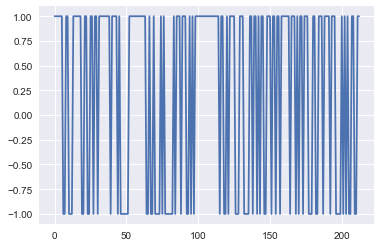

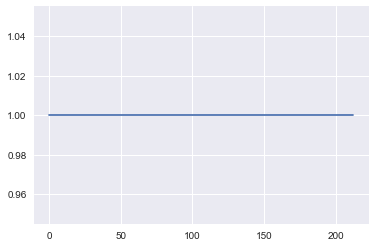

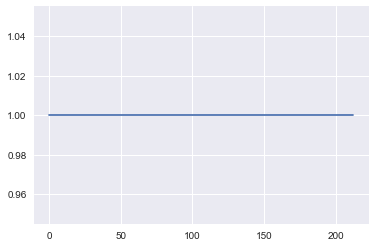

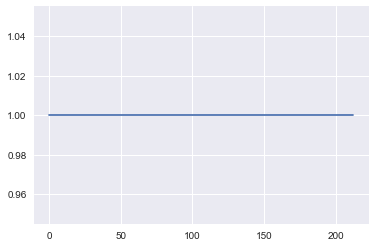

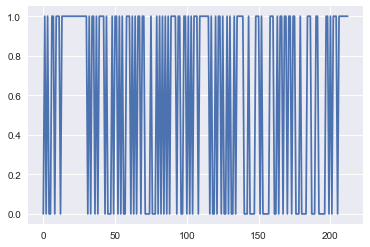

In [28]:
# Step 2: Plot trading signals
for i in range(signal.shape[1]):
    plt.figure(i)
    plt.plot(signal.iloc[:, i])


Now, we finished our trading signals (i.e., buy & sell SPY daily).

#### Step 11: Backtesting

In [47]:
# Step 1: Define SPY's daily returns
spy_df_copy = spy_df.iloc[39:]
ret = pd.DataFrame(spy_df_copy['Close'] / spy_df_copy['Close'].shift(1) - 1).iloc[:-1, :]
ret.iloc[0] = 0.0

,Close
40,0.000000
41,-0.012487
42,-0.010130
43,-0.014541
44,0.005155
...,...
248,-0.026176
249,-0.026423
250,0.050525
251,0.007677


In [49]:
# Step 2: Define SPY's cumulative returns
cum_ret = np.nancumprod(ret + 1)
cum_ret = pd.DataFrame(cum_ret, columns = ['Cum_Ret'])

In [50]:
# Step 3: Combining trading signals with daily returns
final_result = signal.copy(deep = True)
for model in final_result:
    final_result[model] = ret['Close']*signal[model]
    
final_result.dropna(inplace = True)
final_result

,LinearRegression(),Lasso(alpha=0.1),Ridge(alpha=10),ElasticNet(alpha=0.1),"KNeighborsClassifier(leaf_size=5, p=1)"
40,0.000000,0.000000,0.000000,0.000000,0.000000
41,-0.012487,-0.012487,-0.012487,-0.012487,-0.012487
42,-0.010130,-0.010130,-0.010130,-0.010130,-0.010130
43,-0.014541,-0.014541,-0.014541,-0.014541,-0.000000
44,-0.005155,0.005155,0.005155,0.005155,0.005155
...,...,...,...,...,...
208,-0.030299,-0.030299,-0.030299,-0.030299,-0.030299
209,-0.017941,0.017941,0.017941,0.017941,0.017941
210,0.017587,-0.017587,-0.017587,-0.017587,-0.017587
211,-0.005540,-0.005540,-0.005540,-0.005540,-0.005540


In [51]:
final_result.describe()

,LinearRegression(),Lasso(alpha=0.1),Ridge(alpha=10),ElasticNet(alpha=0.1),"KNeighborsClassifier(leaf_size=5, p=1)"
count,173.000000,173.000000,173.000000,173.000000,173.000000
mean,0.000206,-0.000177,-0.000177,-0.000177,0.000155
std,0.008716,0.008717,0.008717,0.008717,0.007173
min,-0.030299,-0.031663,-0.031663,-0.031663,-0.031663
25%,-0.004045,-0.003833,-0.003833,-0.003833,0.000000
50%,0.000476,0.000103,0.000103,0.000103,0.000000
75%,0.004489,0.004751,0.004751,0.004751,0.001330
max,0.031663,0.027359,0.027359,0.027359,0.027359


In [52]:
final_result += 1
final_result = final_result.cumprod()
final_result

,LinearRegression(),Lasso(alpha=0.1),Ridge(alpha=10),ElasticNet(alpha=0.1),"KNeighborsClassifier(leaf_size=5, p=1)"
40,1.000000,1.000000,1.000000,1.000000,1.000000
41,0.987513,0.987513,0.987513,0.987513,0.987513
42,0.977510,0.977510,0.977510,0.977510,0.977510
43,0.963296,0.963296,0.963296,0.963296,0.977510
44,0.958330,0.968262,0.968262,0.968262,0.982549
...,...,...,...,...,...
208,1.020766,0.954732,0.954732,0.954732,1.013273
209,1.002452,0.971860,0.971860,0.971860,1.031452
210,1.020083,0.954768,0.954768,0.954768,1.013312
211,1.014431,0.949478,0.949478,0.949478,1.007698


<AxesSubplot: >

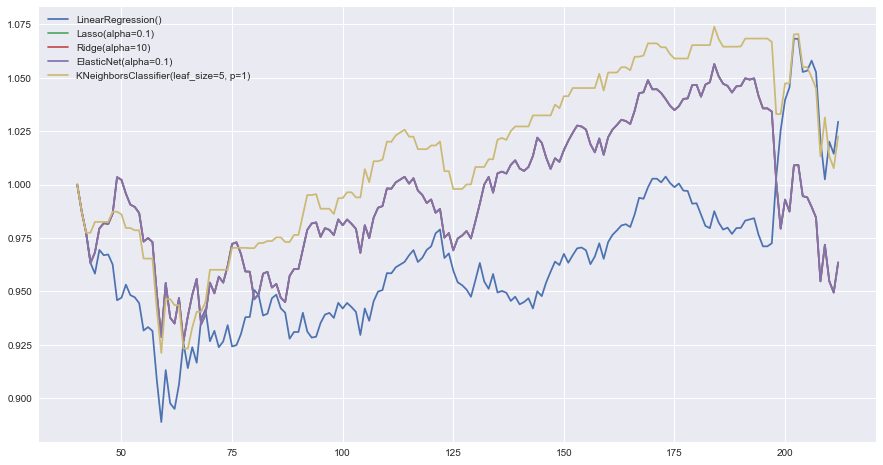

In [57]:
plt.rcParams["figure.figsize"] = (15, 8)
final_result.plot()

Now, we can see that Ridge and Lasso predictions totally disappear in our picture. This is beacause their predictions are overlap with either our Linear Regression or our ElasticNet model. This thing goes quite interesting and needs more caution.

In [58]:
# Step 4: Compare each model with yearly rerturns
year_ret = pow(final_result.iloc[-1].copy(deep = True), 252/213) - 1
year_ret

LinearRegression()                        0.034952
Lasso(alpha=0.1)                         -0.042981
Ridge(alpha=10)                          -0.042981
ElasticNet(alpha=0.1)                    -0.042981
KNeighborsClassifier(leaf_size=5, p=1)    0.026829
Name: 212, dtype: float64

**Conclusion:**

As a result, we can conclude that among all possible models, OLS and kNN are among the best in generating cumulative or annualized returns. OLS did a slightly better job for yearly returns, while kNN generally outperforms all other models for cumulative returns. Since all of these dataset are small and not exciting, we need future research to find out more profitable ways to make money.